**Introduction**<br>
-- 
In this document the extension methodology is mimicked on a simplified dataset. <br>
Approach chosen in the calculator code is to fit an appropriate univariate **AutoRegressive Integrated Moving Average (ARIMA)** time series process to each macroeconomic variable. <br>
The set of ARIMA processes used are:<br>

1. ARIMA(0, 0, 0)
2. ARIMA(1, 0, 0) <br>


**AR: Autoregression:** A model that uses the dependent relationship between an observation and some number of lagged observations.<br>
**I: Integrated:** The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.<br>
**MA: Moving Average:** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.<br>
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.
<br>
A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where:<br>
•p is the number of autoregressive terms,<br>
•d is the number of nonseasonal differences needed for stationarity, and<br>
•q is the number of lagged forecast errors in the prediction equation. <br>
<br>
For example, a ARIMA(1,0, 0) process can be written as:
<br><br>
Y(t) = alpha0 + alpha1Y(t-1) = beta0 + beta1[Y(t-1)-beta0]

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [2]:
from scenario_calculator.modelling.adjustment import (inverse_transform, sample_to_quarterly, sample_to_yearly, transform)
from scenario_calculator.utility import generate_dates
from scenario_calculator.timeseries import _extend_series, _calculate_arima_step

**Transformation and Extension steps on Data**
--

Step 1 is for extension of series while steps 2 -10 are for enrichment of data.

Parameters used:
![image.png](attachment:image.png)

![image.png](attachment:image.png)

**Step 1: Exending TimeSeries**<br>
--
--> All unique scenario's are determined.<br>
--> For each unique time series a subset of data is made based on scenario name. Possible scenario names: baseline, plus, minus, etc.<br>
--> On each subset ARIMA extension is performed and added to the dataframe <br>

This is a sample code snipet of how ARIMA Modelling is performed.

In [3]:
all_data = pd.read_csv('extension_data.csv', delimiter=';', decimal=",")

baseline_data_nlc = all_data[(all_data['scenario'] == 'Baseline_2018Q3_overwrite') & (all_data['time_series_code'] == 'NLC')]
baseline_data_nlcu = all_data[(all_data['scenario'] == 'Baseline_2018Q3_overwrite') & (all_data['time_series_code'] == 'NLCU')]

plus_data_nlc = all_data[(all_data['scenario'] == 'Baseline_Plus_2018Q3_overwrite') & (all_data['time_series_code'] == 'NLC')]
plus_data_nlcu = all_data[(all_data['scenario'] == 'Baseline_Plus_2018Q3_overwrite') & (all_data['time_series_code'] == 'NLCU')]

minus_data_nlc = all_data[(all_data['scenario'] == 'Baseline_Minus_2018Q3_overwrite') & (all_data['time_series_code'] == 'NLC')]
minus_data_nlcu = all_data[(all_data['scenario'] == 'Baseline_Minus_2018Q3_overwrite') & (all_data['time_series_code'] == 'NLCU')]

**Baseline Scenario**
-

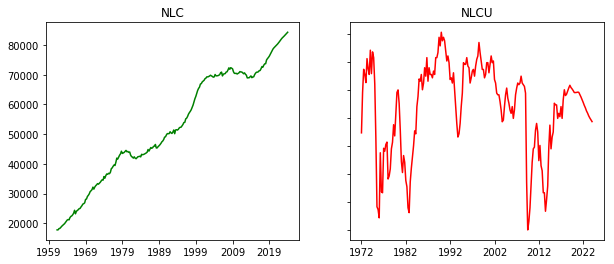

In [4]:
start_nlc = 1961
end_nlc = 2023 + 1
date_index_nlc = pd.date_range(str(start_nlc), str(end_nlc), freq="Q")

start_nlcu = '1971Q4'
end_nlcu = 2023 + 1
date_index_nlcu = pd.date_range(str(start_nlcu), str(end_nlcu), freq="Q")


series_nlc_baseline = pd.Series(baseline_data_nlc['value'].tolist(), date_index_nlc)

series_nlcu_baseline = pd.Series(baseline_data_nlcu['value'].tolist(), date_index_nlcu)

def draw_plot(series_1, series_2, ex_flag):
    f, axarr = pyplot.subplots(1, 2)
    f.set_figwidth(5)
    f.set_figwidth(10)
    axarr[0].plot(series_1, 'g')
    axarr[0].set_title('NLC')
    axarr[1].plot(series_2, 'r')
    axarr[1].set_title('NLCU')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()
        if ex_flag == 1:
            ax.axvline(x='2024', linestyle='--')
            ax.axvline(x='2050', linestyle='--')

draw_plot(series_nlc_baseline, series_nlcu_baseline, 0)

**Performing transformation followed by extension on Baseline Scenario**

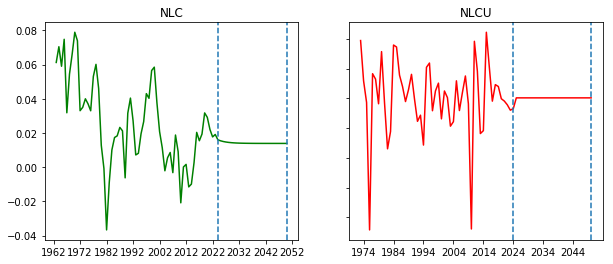

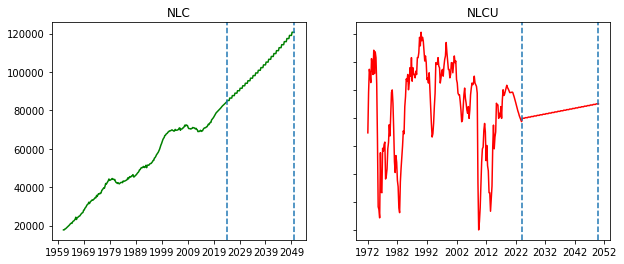

In [5]:
def transform_and_extend(series_nlc, series_nlcu):
    
    ext_series_nlc = series_nlc
    ext_series_nlcu = series_nlcu
    
    # Sample series to yearly frequency:
    ext_series_nlc = sample_to_yearly(ext_series_nlc, "SUM", "A-DEC")
    start_val_nlc = ext_series_nlc.iloc[0]  # The first value of a series is needed for inverse transformation.

    ext_series_nlcu = sample_to_yearly(ext_series_nlcu, "SUM", "A-DEC")
    start_val_nlcu = ext_series_nlcu.iloc[0]  # The first value of a series is needed for inverse transformation.

    # Transformation to correct unit
    ext_series_nlc = transform(ext_series_nlc, "YOY")
    ext_series_nlcu = transform(ext_series_nlcu, "YOY")

    # Start value NLC
    prev_val_nlc = ext_series_nlc[len(ext_series_nlc) - 1]

    # Start value NLCU
    prev_val_nlcu = ext_series_nlcu[len(ext_series_nlcu) - 1]

    start_year_ext = str(2024)
    end_year_ext = str(2050)
    dates = pd.date_range(start_year_ext, end_year_ext, freq='A-DEC')

    # NLC Extension
    ext_series_nlc = _extend_series(ext_series_nlc, dates, prev_val_nlc, param0=0.013883143, param1=0.733993227, param_d=0)

    # NLCU Extension
    ext_series_nlcu =  _extend_series(ext_series_nlcu, dates, prev_val_nlcu, param0=0.000416173, param1=0.0, param_d=0)
    
    ext_yoy_nlc = ext_series_nlc.copy()
    ext_yoy_nlcu = ext_series_nlcu.copy()
        
    draw_plot(ext_series_nlc, ext_series_nlcu, 1)

    # Inverse transform series:
    ext_series_nlc = inverse_transform(ext_series_nlc, "YOY", start_val_nlc)
    last_date_extension_nlc = ext_series_nlc.index[-1]

    ext_series_nlcu = inverse_transform(ext_series_nlcu, "YOY", start_val_nlcu)
    last_date_extension_nlcu = ext_series_nlcu.index[-1]

    # Sample back to quarterly date
    ext_series_nlc = sample_to_quarterly(ext_series_nlc, "SUM")
    ext_series_nlcu = sample_to_quarterly(ext_series_nlcu, "SUM")
    
    # Appending extended series to original data NLC
    last_obs_date = generate_dates(2024 - 1, 2024, 'A-DEC')[0]
    ext_series_nlc = ext_series_nlc[ext_series_nlc.index > last_obs_date]
    series_nlc = series_nlc[series_nlc.index <= last_obs_date]
    series_nlc = series_nlc.append(ext_series_nlc)
    series_nlc = series_nlc[series_nlc.index <= last_date_extension_nlc]
    
    # Appending extended series to original data NLCU
    ext_series_nlcu = ext_series_nlcu[ext_series_nlcu.index > last_obs_date]
    series_nlcu = series_nlcu[series_nlcu.index <= last_obs_date]
    series_nlcu = series_nlcu.append(ext_series_nlcu)
    series_nlcu = series_nlcu[series_nlcu.index <= last_date_extension_nlcu]
    
    # Visualize final extended data
    draw_plot(series_nlc, series_nlcu, 1)
    
    return {'nlc':series_nlc, 'nlcu':series_nlcu, 'ynlc':ext_yoy_nlc, 'ynlcu':ext_yoy_nlcu}
    
ext_baseline = transform_and_extend(series_nlc_baseline, series_nlcu_baseline)

**Baseline Plus Scenario**

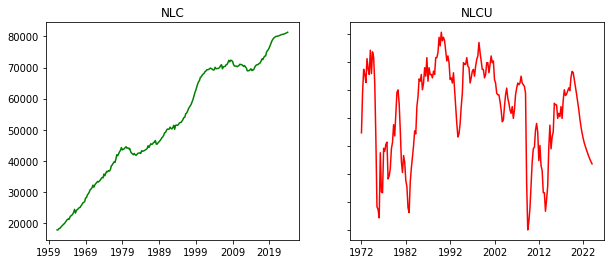

In [6]:
series_nlc_plus = pd.Series(plus_data_nlc['value'].tolist(), date_index_nlc)

series_nlcu_plus = pd.Series(plus_data_nlcu['value'].tolist(), date_index_nlcu)

draw_plot(series_nlc_plus, series_nlcu_plus, 0)

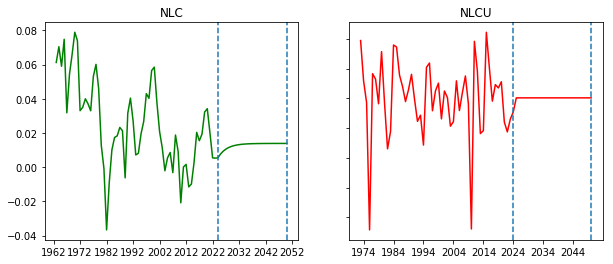

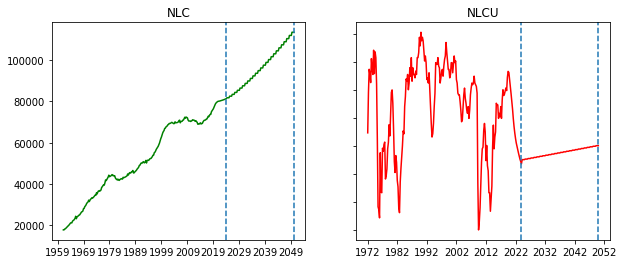

In [7]:
ext_plus_series = transform_and_extend(series_nlc_plus, series_nlcu_plus)

**Baseline Minus Scenario**

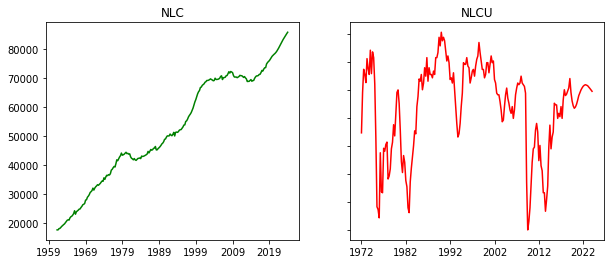

In [8]:
series_nlc_minus = pd.Series(minus_data_nlc['value'].tolist(), date_index_nlc)

series_nlcu_minus = pd.Series(minus_data_nlcu['value'].tolist(), date_index_nlcu)

draw_plot(series_nlc_minus, series_nlcu_minus, 0)

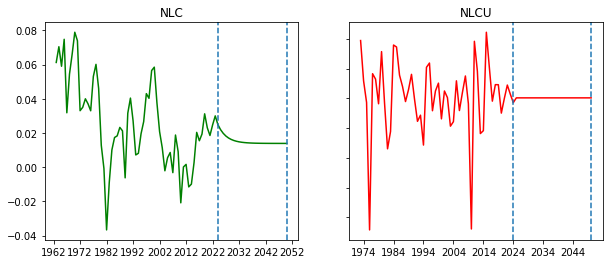

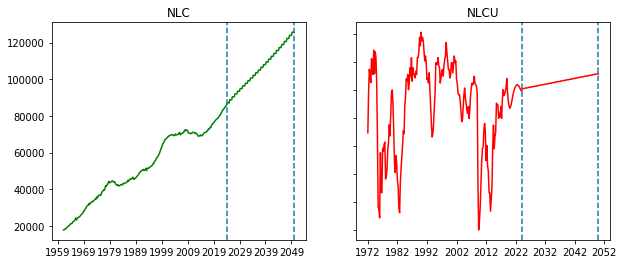

In [9]:
ext_minus_series = transform_and_extend(series_nlc_minus, series_nlcu_minus)

**Plotting all three scenarios together for comparison**

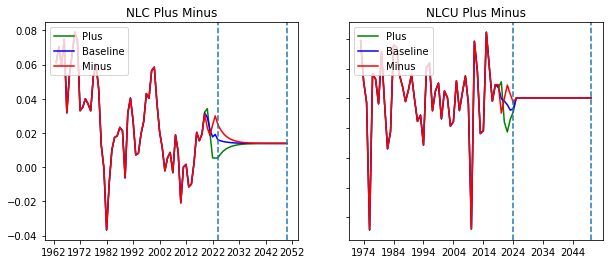

In [10]:
f, axarr = pyplot.subplots(1, 2)
f.set_figwidth(10)
axarr[0].plot(ext_plus_series['ynlc'], 'g', label='Plus')
axarr[0].plot(ext_baseline['ynlc'], 'b', label='Baseline')
axarr[0].plot(ext_minus_series['ynlc'], 'r', label='Minus')
axarr[0].set_title('NLC Plus Minus')
axarr[0].legend(loc='upper left')

axarr[1].plot(ext_plus_series['ynlcu'], 'g', label='Plus')
axarr[1].plot(ext_baseline['ynlcu'], 'b', label='Baseline')
axarr[1].plot(ext_minus_series['ynlcu'], 'r', label='Minus')
axarr[1].set_title('NLCU Plus Minus')
axarr[1].legend(loc='upper left')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    ax.axvline(x='2024', linestyle='--')
    ax.axvline(x='2050', linestyle='--')

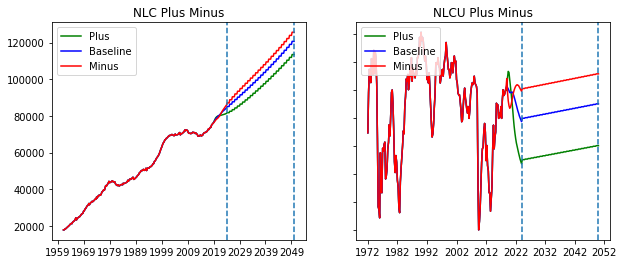

In [11]:
f, axarr = pyplot.subplots(1, 2)
f.set_figwidth(10)
axarr[0].plot(ext_plus_series['nlc'], 'g', label='Plus')
axarr[0].plot(ext_baseline['nlc'], 'b', label='Baseline')
axarr[0].plot(ext_minus_series['nlc'], 'r', label='Minus')
axarr[0].set_title('NLC Plus Minus')
axarr[0].legend(loc='upper left')

axarr[1].plot(ext_plus_series['nlcu'], 'g', label='Plus')
axarr[1].plot(ext_baseline['nlcu'], 'b', label='Baseline')
axarr[1].plot(ext_minus_series['nlcu'], 'r', label='Minus')
axarr[1].set_title('NLCU Plus Minus')
axarr[1].legend(loc='upper left')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    ax.axvline(x='2024', linestyle='--')
    ax.axvline(x='2050', linestyle='--')

**Step 2: Apply fallback for missing series**
--
--> Remove series that are not part of the series defined in the reference set.<br>
--> Apply fallback for series expected in the input.<br>
--> It could be that some expected microeconomic variables are missing, we define fallbacks here to handle such scenarios!

**Step 3: Deriving new parameters**
--
--> For each country code, first clean the series of NaN values<br>
--> Derive additional macro-economic variables: GDPperCapPOPT, GDPperCapPOPWA, RRM3. If the working age population (POPWA) exists for a country, then the GDP per capita is calculated as the GDP divided by POPWA, otherwise the total population is used.


**Step 4: Unit Conversion**
--
--> Four variables are converted from percentage to decimal: LR, R3M, RR4M and U.<br>
--> The variables GDP and PSI are expressed in millions for some countries and in billions for others.<br> 
--> For the most recent conversion factors we refer to "Macro-economic data used for IFRS9 & Stress Testing".<br>

**Step 5: Apply Regression Modelling**
--
Returns the linear combination of four regressor series, a constant and an autoregressive term, given by:<br>

    y[i] = a_1 + a_2*y[i-1] + b_1*x_1 + b_2*x_2 + b_3*x_3 + b_4*x_4

Input series need to contain the regressor, already multiplied by their respective coefficient.

**Note:** Regression code snippet is in 3rd Jupyter Notebook

**Step 6: Aggregation to yearly data**
--
The process of converting quarterly data to yearly data is called "aggregation".
<br>
<br>
--> Quarterly data to yearly data for the time series in the dictionary.<br>
--> This is required for applying transforamtions in the next step.

**Step 7: Transforming from ABS to YOY and Y-Y**
--
This step is performed on aggregated values of each quater.<br>

1. YoY -- Calculates relative change between two consecutive time series observations -- series1 / series2

2. Y-Y -- Calculates absolute change between two consecutive time series observations -- series - series.shift(lag)


**Step 8: Combining transformed-aggregated data**
--
All possible scenarios for each aggregated quater(converted to year in step 6)are added to the dictionary.

**Step 9: Setting standardization parameter**
--
The series is then standerdized by subracting the mean and divind by standart deviation.<br>
If historical data is not available for getting the mean and SD, we leave the series as it is.

**Step 10: Mapping Missing Series and Countries**
--

Here we replace the values of the missing countries as defined by the bussiness rules.